# Preparation of initial box for coexsistence simulations

In [9]:
import numpy as np, sys, os, glob
import matplotlib.pylab as plt
import MDAnalysis
import pickle

In [3]:
standard_sim=os.path.abspath('template/')
press_box = np.genfromtxt('../1-Bulk/avg_IceV_box.dat')
single_pressure=None #'7000'
#temps=np.array([245,250,255,260,265,270])

In [ ]:
### First step: equilibrate ice box

In [6]:
sims = dict()
for a in press_box[:]:
    fold='BOX_EQUIL_{}bar/'.format(a[0])
    if single_pressure==None or single_pressure in fold:
        sims[fold] = dict()
        sims[fold]['p']=a[0]
        os.system('mkdir -p {}'.format(fold))
        os.system('cp -r {}/* {}'.format(standard_sim,fold))
        cmd='sed -i "" "s#variable .* pressure .*#variable        pressure equal {}#g" {}/in.pressure'.format(sims[fold]['p'],fold)
        os.system(cmd)

### Second step: Determine average box dimensions

In [10]:
def extract_form_log(fn):
    lines=open(fn,'r').readlines()
    start=np.where([('Step' in l) for l in lines])[-1][0]
    data={keyi.lower(): []  for keyi in lines[start].split()}
    for l in lines[start+1:]:
        ls=l.split()
        try:
            if ls[0].isdigit():
                for i, key in enumerate(data.keys()):
                    data[key].append(float(ls[i]))
        
            else:
                break
        except:
            break
    for key in data.keys():
        data[key]=np.array(data[key])
    return data

In [11]:
box_equil=dict()
for f in glob.glob('BOX_EQUIL_*/log.lammps'): 
    box_equil[f.replace('/log.lammps','')]=extract_form_log(f)


with open('box_size.pickle', 'wb') as handle:
    pickle.dump(box_equil, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('box_size.pickle', 'rb') as handle:
    box_equil = pickle.load(handle)
print(box_equil.keys())

dict_keys(['BOX_EQUIL_8000.0bar', 'BOX_EQUIL_4000.0bar', 'BOX_EQUIL_3500.0bar', 'BOX_EQUIL_7500.0bar', 'BOX_EQUIL_5000.0bar', 'BOX_EQUIL_7000.0bar', 'BOX_EQUIL_6000.0bar'])


Text(0, 0.5, 'v/Å$^3$')

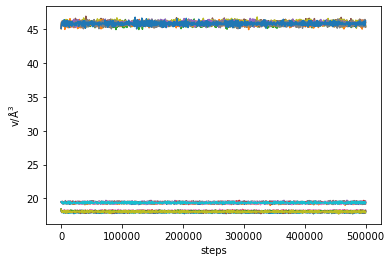

In [12]:
for key in box_equil.keys():
    plt.plot(box_equil[key]['step'],box_equil[key]['lx'])
    plt.plot(box_equil[key]['step'],box_equil[key]['lz'])
    plt.plot(box_equil[key]['step'],box_equil[key]['ly'])
plt.xlabel('steps')
plt.ylabel(r'v/Å$^3$')

In [23]:
for fold in box_equil.keys():
    sim=box_equil[fold]
    #print(sim)                                                                                                                                                                              
    # Scale box                                                                                                                                                                              
    u = MDAnalysis.Universe(fold+'/ice_equil.data', in_memory=True)
    NIGNORE=int(0.25*len(box_equil[key]['step']))
    
    lx=np.mean(sim['lx'][NIGNORE:])
    xy=np.mean(sim['xy'][NIGNORE:])
    xz=np.mean(sim['xz'][NIGNORE:])
    ly=np.mean(sim['ly'][NIGNORE:])
    yz=np.mean(sim['yz'][NIGNORE:])
    lz=np.mean(sim['lz'][NIGNORE:])
    print(xy,xz,yz)
    A=np.array([[lx,0,0],
                 [xy,ly,0],
                 [xz,yz,lz]])
    dimensions_new=MDAnalysis.lib.mdamath.triclinic_box(A[0], A[1], A[2])
    u.coord.positions[:,0] = u.coord.positions[:,0]*lx/u.dimensions[0]
    u.coord.positions[:,1] = u.coord.positions[:,1]*ly/u.dimensions[1]
    u.coord.positions[:,2] = u.coord.positions[:,2]*lz/u.dimensions[2]
    u.dimensions[0]=dimensions_new[0]
    u.dimensions[1]=dimensions_new[1]
    u.dimensions[2]=dimensions_new[2]
    u.dimensions[3]=dimensions_new[3]
    u.dimensions[4]=dimensions_new[4]
    u.dimensions[5]=dimensions_new[5]

    u.atoms.write(fold+'/ice_avg_equil.data')

-0.2808189033401331 -6.470894128628496 0.10989709856071905
dict_items([('bond', <TopologyGroup containing 1344 bonds>), ('angle', <TopologyGroup containing 672 angles>), ('dihedral', <TopologyGroup containing 0 dihedrals>), ('improper', <TopologyGroup containing 0 impropers>)])
bond ['1']
angle ['1']
dihedral []
improper []
-0.2662421586125433 -6.589954363382157 0.09984278254753662
dict_items([('bond', <TopologyGroup containing 1344 bonds>), ('angle', <TopologyGroup containing 672 angles>), ('dihedral', <TopologyGroup containing 0 dihedrals>), ('improper', <TopologyGroup containing 0 impropers>)])
bond ['1']
angle ['1']
dihedral []
improper []
-0.2680453425693608 -6.606029808255659 0.09724317946699068
dict_items([('bond', <TopologyGroup containing 1344 bonds>), ('angle', <TopologyGroup containing 672 angles>), ('dihedral', <TopologyGroup containing 0 dihedrals>), ('improper', <TopologyGroup containing 0 impropers>)])
bond ['1']
angle ['1']
dihedral []
improper []
-0.27168786491395475 -

### Third step: Melt half the box

In [25]:
for a in press_box[:]:
    fold='BOX_MELT_{}bar/'.format(a[0])
    os.system('mkdir -p {}'.format(fold))
    os.system('cp -r {}/ice_avg_equil.data {}'.format(fold.replace('MELT','EQUIL'),fold))
    os.system('cp -r {}/* {}'.format(standard_sim,fold))
    cmd='sed -i "" "s#variable .* pressure .*#variable        pressure equal {}#g" {}/in.pressure'.format(a[0],fold)
    os.system(cmd)

### Fourth step: collect data files

In [26]:
fold_out='COEX_BOXES/'
os.system('mkdir -p {}'.format(fold_out))
for a in press_box[:]:
    fold='BOX_MELT_{}bar/'.format(a[0])
    os.system('cp {}/water.data.equil {}/{}'.format(fold,fold_out,'water_{}bar.data'.format(a[0])))

### Convert notebook to python script

In [1]:
!jupyter nbconvert --to script Prepare_coexsistence.ipynb


[NbConvertApp] Converting notebook Prepare_coexsistence.ipynb to script
[NbConvertApp] Writing 3646 bytes to Prepare_coexsistence.py
